In [1]:
%%time 
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import HTML, display
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn_pandas import DataFrameMapper

plt.rcParams['figure.figsize'] = 25, 10

CPU times: user 1.01 s, sys: 202 ms, total: 1.21 s
Wall time: 977 ms


In [2]:
def load_notebook_config(width=True):
    pd.options.display.max_columns = 0
    plt.rcParams.update({
        "font.family": ["serif"],
        "font.sans-serif": ["Roboto"],
        "font.size": 9,
        "axes.labelsize": 11,
        "axes.titlesize": 13,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 11,
        'figure.figsize': (15.0, 4.0),
        'axes.grid': False,
        'axes.spines.left': True,
        'axes.spines.right': True,
        'axes.spines.top': True,
        'axes.spines.bottom': True,
    })
    if width:
        display(HTML("<style>.container { width:90% !important; }</style>"))

load_notebook_config()

# TP 2: Entrenamiento y evaluación de modelos

## Introducción

El conjunto de datos sobre el que se realizará el entrenamiento y evaluación contiene datos historicos de préstamos emitidos en el período 2010-2018. El target a tratar es el loan_status, que determina si un prestamo fue pagado o no.
Cabe resaltar que se toma como base el dataset obtenido en el tp1 tras realizar la limpieza y preprocesado de datos.

Para el entrenamiento del modelo, las features elegidas son: 


| Feature      |Definición                                                                |
|:--------------|:-------------------------------------------------------------------------|
| annual_inc    | Ingreso anual informado proporcionado por el prestatario.                | 
| delinq_amnt   | Monto adeudado por las cuentas que el prestatario está en mora actualmente.|
| disbursement_method  | Método por el cual el pestatario recibe su préstamo. Puede ser CASH (efectivo), DIRECT PAY (pago directo).|
| dti  | Relación entre los pagos mensuales totales de la deuda dividido por el ingreso mensual informado del prestatario.|  
| emp_length  | Duración del empleo en años.| 
| funded_amnt  | Monto total comprometido con el préstamo hasta el momento.|
| home_ownership  | El estado de propiedad de la vivienda del prestatario. | 
| int_rate  | Tasa de interés del préstamo.                | 
| purpose  | Propósito del préstamo definido por el préstatario para la solicitud de préstamo|      
| term  | Número de meses de pago del préstamo.                 | 


No seran utilizadas:
- **acc_now_delinq:** Consideramos que la informacion que brinda es redundante a la feature delinq_amnt
- **grade:** Porque que la información que brinda es redundante a la feature int_rate, ya que en funcion a la clasificacion del grado del prestatario, se calcula la tasa de interes del préstamo otorgado.   
- **installment:** Ya que es el valor de la division de funded_amnt sobre term.
- **total_pymnt:** Al momento de predecir esta información no estara disponible. 

## Métrica:
La métrica que utilizaremos para la evaluación de los modelos es **Precision**. 

Consideramos que tiene mucha importancia cuando el modelo predice que un prestamo se va a pagar, porque que en el caso de que que la prediccion no sea correcta representaria una pérdida económica.

Como ya se definio en el tp1, la metrica Accuracy no será utilizada debido al desbalanceo de datos que presenta el dataset (80% Fully Paid y 20% No Paid).

In [3]:
#Descomprimir dataset
#all_data=pd.read_csv('./dataset/process_data.csv')

all_data = pd.read_csv('./dataset/process_data.zip', compression='zip', header=0, sep=',', quotechar='"')


In [4]:
#Forma del dataset
all_data.shape

(1303638, 15)

In [5]:
#Cantidad de nulos
all_data.isnull().sum()

funded_amnt                0
term                       0
int_rate                   0
installment                0
emp_length             75457
home_ownership             0
annual_inc                 0
loan_status                0
purpose                    0
total_pymnt                0
acc_now_delinq             0
delinq_amnt                0
disbursement_method        0
grade                      0
dti                      312
dtype: int64

In [6]:
#CONVIERTO FULLY PAID= 1 NO PAID=0

In [7]:
all_data.loan_status=all_data.loan_status.replace({'Fully Paid': 1, 'No Paid':0})

In [8]:
all_data.head()

funded_amnt        term  int_rate  installment emp_length home_ownership  ...   total_pymnt  acc_now_delinq delinq_amnt  disbursement_method  grade    dti
0        30000   36 months     22.35      1151.16    5 years       MORTGAGE  ...  30026.442500             0.0         0.0                 Cash      D  30.46
1        40000   60 months     16.14       975.71   < 1 year       MORTGAGE  ...  40856.678960             0.0         0.0                 Cash      C  50.53
2        20000   36 months      7.56       622.68  10+ years       MORTGAGE  ...  20215.792430             0.0         0.0                 Cash      A  18.92
3         4500   36 months     11.31       147.99  10+ years           RENT  ...   4549.217149             0.0         0.0                 Cash      B   4.64
4         8425   36 months     27.27       345.18    3 years       MORTGAGE  ...   8735.148975             0.0         0.0                 Cash      E  12.37

[5 rows x 15 columns]

In [9]:
#Convierto los valores other y none en any para owner_ship 

In [10]:
all_data.home_ownership.value_counts()

MORTGAGE    645509
RENT        517821
OWN         139849
ANY            267
OTHER          144
NONE            48
Name: home_ownership, dtype: int64

In [11]:
all_data.home_ownership=all_data.home_ownership.replace({'OTHER': 'ANY', 'NONE':'ANY'})

In [12]:
all_data.home_ownership.value_counts()

MORTGAGE    645509
RENT        517821
OWN         139849
ANY            459
Name: home_ownership, dtype: int64

In [13]:
#Emp_length none=0 (tomamos a none como desempleado) y convierto feature categorica a numerica

In [14]:
all_data.emp_length.isnull().sum()

75457

In [15]:
all_data.emp_length.value_counts()

10+ years    428553
2 years      117825
< 1 year     104552
3 years      104204
1 year        85678
5 years       81623
4 years       78033
6 years       60934
8 years       59127
7 years       58148
9 years       49504
Name: emp_length, dtype: int64

In [16]:
all_data['emp_length'].fillna(value=0,inplace=True)

all_data['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)

In [17]:
all_data.emp_length.value_counts()

10    428553
1     190230
2     117825
3     104204
5      81623
4      78033
0      75457
6      60934
8      59127
7      58148
9      49504
Name: emp_length, dtype: int64

In [18]:
all_data.emp_length.isnull().sum()

0

In [19]:
#DTI relleno nulos con el promedio.

In [20]:
all_data.dti.isnull().sum()

312

In [21]:
all_data.dti

0          30.46
1          50.53
2          18.92
3           4.64
4          12.37
           ...  
1303633    23.22
1303634     8.08
1303635    33.24
1303636    14.66
1303637    19.28
Name: dti, Length: 1303638, dtype: float64

In [22]:
all_data['dti'].fillna(all_data['dti'].mean(),inplace=True)

In [23]:
all_data.dti.isnull().sum()

0

In [24]:
# SEPARO ALL_DATA en Train, Test y Validation.

In [25]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(all_data, test_size=0.4, random_state=42)
validation, test = train_test_split(not_train, test_size=0.5, random_state=42)

In [26]:
train

funded_amnt        term  int_rate  installment emp_length home_ownership  ...   total_pymnt  acc_now_delinq delinq_amnt  disbursement_method  grade    dti
261554         23925   60 months     21.48       653.73          1           RENT  ...   6515.690000             0.0         0.0                 Cash      E  17.79
462164         10775   36 months     16.99       384.11          7           RENT  ...   7622.630000             0.0         0.0                 Cash      D  19.88
1109068        20000   36 months     10.15       646.76         10       MORTGAGE  ...  21702.510000             0.0         0.0                 Cash      B  23.79
269446         10925   36 months     17.99       394.92          4            OWN  ...   7245.880000             0.0         0.0                 Cash      D  19.44
629754         12000   36 months     13.33       406.24         10       MORTGAGE  ...   6922.400000             0.0         0.0                 Cash      C  13.62
...              ...         ...       ...          ...        ...            ...  ...           ...             ...         ...                  ...    ...    ...
110268         14000   36 months     13.49       475.03          2           RENT  ...  15307.752168             0.0         0.0                 Cash      C  17.62
259178         25000   36 months      5.32       752.87         10       MORTGAGE  ...  25333.030000             0.0         0.0                 Cash      A   1.57
131932         21600   36 months      9.75       694.44          8           RENT  ...  23979.193655             0.0         0.0                 Cash      B  12.21
671155         21125   60 months     12.99       480.56          2       MORTGAGE  ...  11165.410000             0.0         0.0                 Cash      C  21.00
121958         12000   36 months      5.32       361.38         10       MORTGAGE  ...  12205.800000             0.0         0.0                 Cash      A  18.22

[782182 rows x 15 columns]

In [27]:
test

funded_amnt        term  int_rate  installment emp_length home_ownership  ...   total_pymnt  acc_now_delinq delinq_amnt  disbursement_method  grade    dti
435765         20000   60 months     18.25       510.60         10           RENT  ...  27452.256857             0.0         0.0                 Cash      E  24.99
345093         15000   36 months     18.20       543.80          3       MORTGAGE  ...  19494.133866             0.0         0.0                 Cash      E  21.11
1142186        28775   36 months     19.52      1062.36         10       MORTGAGE  ...  35187.040000             0.0         0.0                 Cash      E  29.84
605282         15000   36 months      7.89       469.29         10       MORTGAGE  ...  16842.200427             0.0         0.0                 Cash      A  20.87
184854         26975   60 months     11.47       592.85         10       MORTGAGE  ...  31569.832360             0.0         0.0                 Cash      B  27.64
...              ...         ...       ...          ...        ...            ...  ...           ...             ...         ...                  ...    ...    ...
718223          4200   36 months     22.74       162.02          3       MORTGAGE  ...   4927.787431             0.0         0.0                 Cash      E  26.34
419533         21775   60 months     17.57       547.87          7           RENT  ...   7458.330000             0.0         0.0                 Cash      D  34.64
1073273         4000   36 months     13.98       136.68          9       MORTGAGE  ...   4920.685504             2.0       490.0                 Cash      C  21.10
916232         17050   36 months     10.16       551.44         10       MORTGAGE  ...  19819.840020             0.0         0.0                 Cash      B  27.51
1032375        11000   36 months      8.19       345.67         10           RENT  ...  11494.860000             0.0         0.0                 Cash      A   6.28

[260728 rows x 15 columns]

In [28]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, KBinsDiscretizer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.pipeline import Pipeline

## MAPPER

In [29]:
complete_mapper= DataFrameMapper([
    
    (['funded_amnt'],[StandardScaler(), KBinsDiscretizer(encode='ordinal',strategy='quantile')]), #BINNING
    (['term'],[OneHotEncoder()]),
    (['int_rate'],[StandardScaler()]),
    (['emp_length'],[StandardScaler()]),
    (['home_ownership'],[OneHotEncoder()]),
    (['annual_inc'],[StandardScaler(),KBinsDiscretizer(encode='ordinal',strategy='quantile')]), #BINNING
    (['purpose'],[OneHotEncoder()]),
    (['delinq_amnt'],[StandardScaler()]),
    (['disbursement_method'],[OneHotEncoder()]),
    (['dti'],[StandardScaler()]),   
])

#complete_mapper.fit(train)



### Se realizo binning de las features: 
- **funded_amnt**
- **annual_inc**

En ambos casos, se juntan en rangos los valores de las features para evitar el sobreentrenamiento de los modelos.
Para el Binning, utilizamos KBinsDiscretizer que forma parte de Sklearn.

## Función para evaluar los modelos

In [30]:
%%time 
def evaluate_model(model, set_names=('train', 'test'), title='', show_cm=True):
    if title:
        display(title)
    final_metrics = defaultdict(list)
    if show_cm:
        fig, axis = plt.subplots(1, len(set_names), sharey=True, figsize=(15, 3))
    
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'test', 'validation']
        set_data = globals()[set_name] # <- hack feo...

        y = set_data.loan_status
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        

        if show_cm:
            ax = axis[i]
            sns.heatmap(metrics.confusion_matrix(y, y_pred), ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=False)

            ax.set_title(set_name)
            ax.xaxis.set_ticklabels(['No Paid','Fully Paid'])
            ax.yaxis.set_ticklabels(['No Paid','Fully Paid'])
            ax.set_xlabel('Predicted class')
            ax.set_ylabel('True class')


    display(pd.DataFrame(final_metrics, index=set_names))
    if show_cm:
        plt.tight_layout()
        plt.show()


CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11.9 µs


# Modelo 1: Regresión lineal

In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:
%%time
lr_model= Pipeline([
    ('mapper',complete_mapper),
    ('imputer',SimpleImputer(strategy='mean')),
    ('classifier',LogisticRegression(n_jobs=-1,class_weight='balanced',random_state=42,max_iter=1303638))
])

lr_model.fit(train,train.loan_status)

CPU times: user 2.25 s, sys: 342 ms, total: 2.59 s
Wall time: 1min 15s


Pipeline(steps=[('mapper',
                 DataFrameMapper(features=[(['funded_amnt'],
                                            [StandardScaler(),
                                             KBinsDiscretizer(encode='ordinal')]),
                                           (['term'], [OneHotEncoder()]),
                                           (['int_rate'], [StandardScaler()]),
                                           (['emp_length'], [StandardScaler()]),
                                           (['home_ownership'],
                                            [OneHotEncoder()]),
                                           (['annual_inc'],
                                            [StandardScaler(),
                                             KBinsDiscretizer(encode='ordinal')]),
                                           (['purpose'], [OneHotEncoder()]),
                                           (['delinq_amnt'],
                                            [StandardScaler(

Accuracy  Precision    Recall
train  0.660259   0.874866  0.671084
test   0.660869   0.875171  0.671478

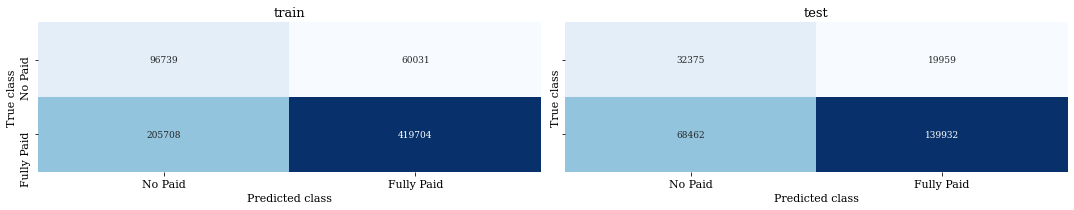

CPU times: user 4.91 s, sys: 777 ms, total: 5.68 s
Wall time: 4.54 s


In [33]:
%%time
evaluate_model(lr_model)

In [34]:
##Coeficientes de Regresion lineal

array([[-0.07323485,  0.25527436, -0.19805525, -0.51864251,  0.0604093 ,
         0.16596425,  0.15091465, -0.05797006, -0.20168973,  0.0910219 ,
         0.18522866,  0.08214237,  0.02040596, -0.27991712, -0.0530822 ,
         0.1805585 , -0.00390893, -0.10803888, -0.06259455,  0.0137535 ,
        -0.1325581 , -0.3668784 , -0.02569797,  0.60780626, -0.00993656,
        -0.10147675,  0.15869586, -0.17195416]])

CPU times: user 144 ms, sys: 4.43 ms, total: 148 ms
Wall time: 147 ms


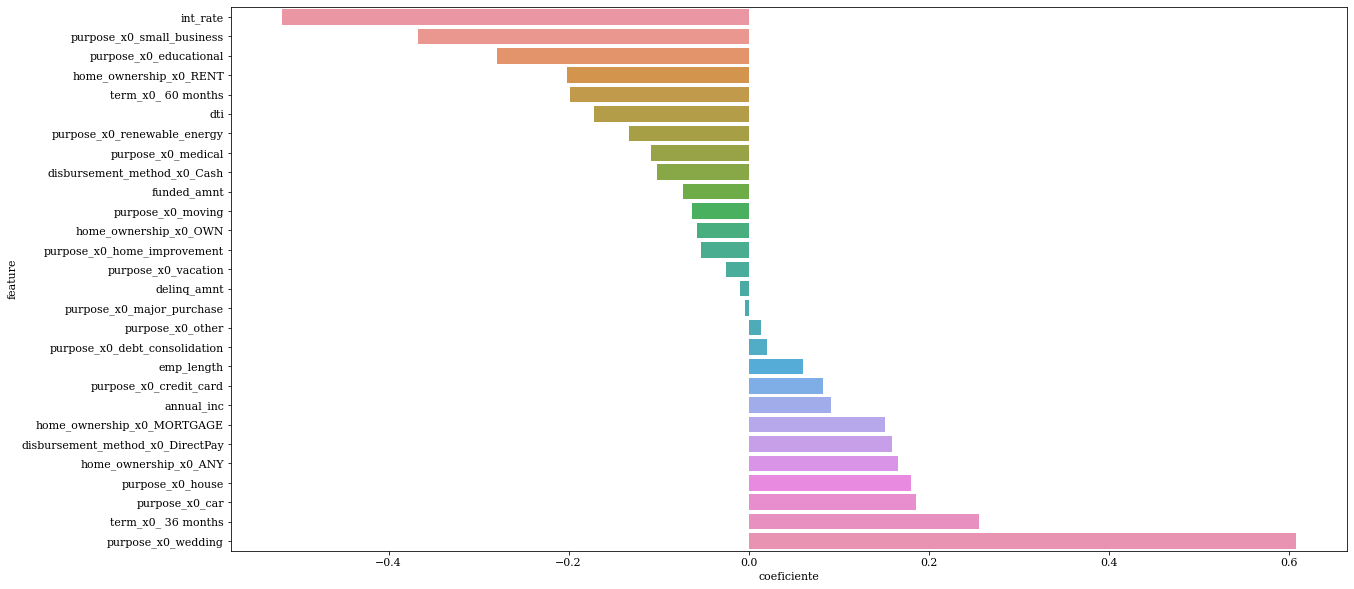

In [35]:
%%time 
clf = lr_model.named_steps['classifier']
display(clf.coef_)

plt.figure(figsize=(20, 10))

names = complete_mapper.transformed_names_
df_importance = pd.DataFrame({'feature': names, 'coeficiente': clf.coef_[0]}).sort_values(by='coeficiente')
ax = sns.barplot(x='coeficiente', y='feature', data=df_importance)

### Conclusión:

Con este modelo el valor de la métrica elegida es de: 0.875171 utilizando el dataset de test. Lo que significa que la probabilidad de que el modelo acierte sobre los prestamos que se van a pagar es de aproximadamente 87%.

Como se puede observar en el grafico de coeficientes, mientas mas alto sea el interés, es mas propenso que un prestamo sea No Paid y al contrario con la variable purpose_x0_wedding. 

## Arboles

In [36]:
%%time 
label_binarizer_mapper= DataFrameMapper([
    (['funded_amnt'],[StandardScaler(),KBinsDiscretizer(encode='ordinal',strategy='quantile')]), #BINNING
    (['term'],[LabelBinarizer()]),
    (['int_rate'],[StandardScaler()]),
    (['emp_length'],[StandardScaler()]),
    (['home_ownership'],[LabelBinarizer()]),
    (['annual_inc'],[StandardScaler(),KBinsDiscretizer(encode='ordinal',strategy='quantile')]), #BINNING
    (['purpose'],[LabelBinarizer()]),
    (['delinq_amnt'],[StandardScaler()]),
    (['disbursement_method'],[LabelBinarizer()]),
    (['dti'],[StandardScaler()]), 
    
])

#label_binarizer_mapper.fit(train)

CPU times: user 116 µs, sys: 0 ns, total: 116 µs
Wall time: 121 µs


## Funcion para evaluar la importancia de las features en los arboles

In [37]:
def evaluate_feature(model, show_cm=True):
    forest=model.named_steps['classifier']
    display(forest.feature_importances_)
    feat_importances = pd.Series(forest.feature_importances_, index= label_binarizer_mapper.transformed_names_)     
    plt.figure(figsize=(20, 10))
    features= pd.DataFrame({'features':feat_importances.index,'values':feat_importances.values})
    ax=sns.barplot(x='values',y='features',data=features)

## Funcion para graficar árboles

In [38]:
%%time 
import graphviz  # pip install graphviz
from sklearn.tree import export_graphviz

def graph_tree(tree, col_names):
    graph_data = export_graphviz(
        tree, 
        out_file=None, 
        feature_names=col_names,  
        class_names=['No Paid', 'Fully Paid'],  
        filled=True, 
        rounded=True,  
        special_characters=True,
    )
    graph = graphviz.Source(graph_data)  
    return graph

CPU times: user 10.8 ms, sys: 86 µs, total: 10.9 ms
Wall time: 10.2 ms


## Modelo 2: Arbol de decisión 

In [39]:
from sklearn.tree import DecisionTreeClassifier


In [40]:
%%time 
tree_model = DecisionTreeClassifier(max_depth=11,min_samples_leaf=10,class_weight='balanced', random_state=42)

dt_model = Pipeline([
    ('mapper', label_binarizer_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', tree_model),
])

dt_model.fit(train, train.loan_status)

CPU times: user 8min 22s, sys: 1min 25s, total: 9min 47s
Wall time: 3min 2s


Pipeline(steps=[('mapper',
                 DataFrameMapper(features=[(['funded_amnt'],
                                            [StandardScaler(),
                                             KBinsDiscretizer(encode='ordinal')]),
                                           (['term'], [LabelBinarizer()]),
                                           (['int_rate'], [StandardScaler()]),
                                           (['emp_length'], [StandardScaler()]),
                                           (['home_ownership'],
                                            [LabelBinarizer()]),
                                           (['annual_inc'],
                                            [StandardScaler(),
                                             KBinsDiscretizer(encode='ordinal')]),
                                           (['purpose'], [LabelBinarizer()]),
                                           (['delinq_amnt'],
                                            [StandardScal

'Decision Tree'

Accuracy  Precision    Recall
train  0.628026   0.889972  0.610228
test   0.621813   0.884699  0.605790

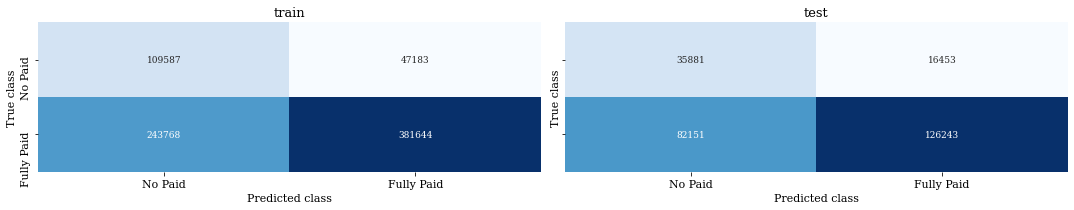

CPU times: user 11.8 s, sys: 460 ms, total: 12.2 s
Wall time: 11.8 s


In [41]:
%%time
evaluate_model(dt_model, title='Decision Tree')

In [42]:
%%time
graph_tree(tree_model, col_names=label_binarizer_mapper.transformed_names_)

CPU times: user 461 ms, sys: 17.4 ms, total: 478 ms
Wall time: 472 ms


array([1.41469428e-02, 5.66310008e-02, 7.49033070e-01, 2.78242723e-02,
       0.00000000e+00, 3.29615892e-02, 6.70178910e-04, 1.34294541e-02,
       1.61434979e-02, 5.21053787e-04, 1.71445473e-03, 1.41245684e-03,
       0.00000000e+00, 7.04855705e-04, 4.97903225e-04, 4.52809134e-04,
       4.21005354e-04, 2.06352963e-04, 1.20450867e-03, 0.00000000e+00,
       1.82422716e-03, 3.33160371e-04, 4.48768066e-04, 2.88527270e-04,
       5.70155345e-04, 7.85597554e-02])

CPU times: user 102 ms, sys: 8.3 ms, total: 110 ms
Wall time: 105 ms


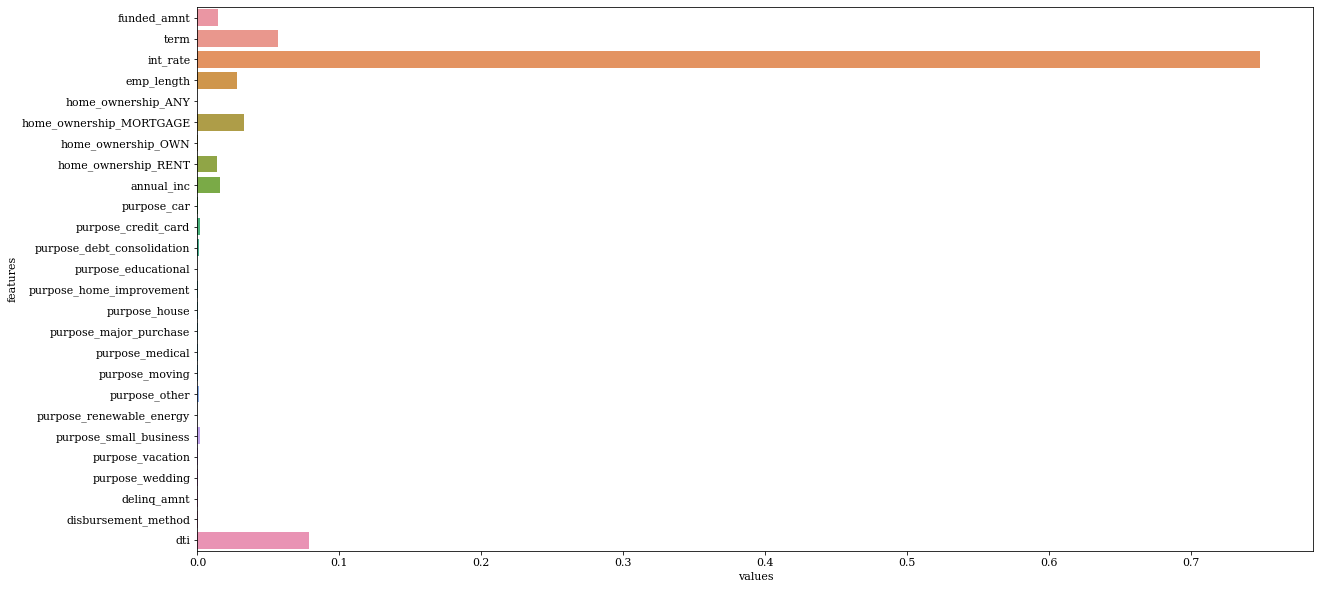

In [43]:
%%time
evaluate_feature(dt_model)

### Conclusión:

Con este modelo el valor de la métrica elegida es de: 0.884699 sobre el conjunto de datos de train. Lo que significa que la probabilidad de que el modelo acierte sobre los prestamos que se van a pagar es de aproximadamente 88%.

Para este modelo, se tuvieron que especificar algunos hiperparametros para evitar el sobreentrennamiento.

# Ensembles 

## Modelo 3: Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
%%time 

forest_model = RandomForestClassifier(n_jobs=-1,max_depth=4, class_weight='balanced', random_state=42, n_estimators=25)

rf_model = Pipeline([
    ('mapper', label_binarizer_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model),
])

rf_model.fit(train, train.loan_status)

CPU times: user 8min 55s, sys: 1min 28s, total: 10min 23s
Wall time: 3min 5s


Pipeline(steps=[('mapper',
                 DataFrameMapper(features=[(['funded_amnt'],
                                            [StandardScaler(),
                                             KBinsDiscretizer(encode='ordinal')]),
                                           (['term'], [LabelBinarizer()]),
                                           (['int_rate'], [StandardScaler()]),
                                           (['emp_length'], [StandardScaler()]),
                                           (['home_ownership'],
                                            [LabelBinarizer()]),
                                           (['annual_inc'],
                                            [StandardScaler(),
                                             KBinsDiscretizer(encode='ordinal')]),
                                           (['purpose'], [LabelBinarizer()]),
                                           (['delinq_amnt'],
                                            [StandardScal

'Random Forest'

Accuracy  Precision    Recall
train  0.619375   0.882429  0.604507
test   0.619891   0.882946  0.604586

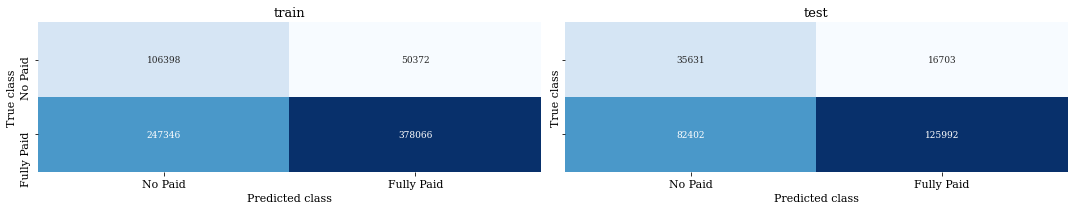

CPU times: user 14.4 s, sys: 443 ms, total: 14.9 s
Wall time: 12.6 s


In [46]:
%%time
evaluate_model(rf_model, title='Random Forest')

CPU times: user 4.46 ms, sys: 3.42 ms, total: 7.88 ms
Wall time: 6.66 ms


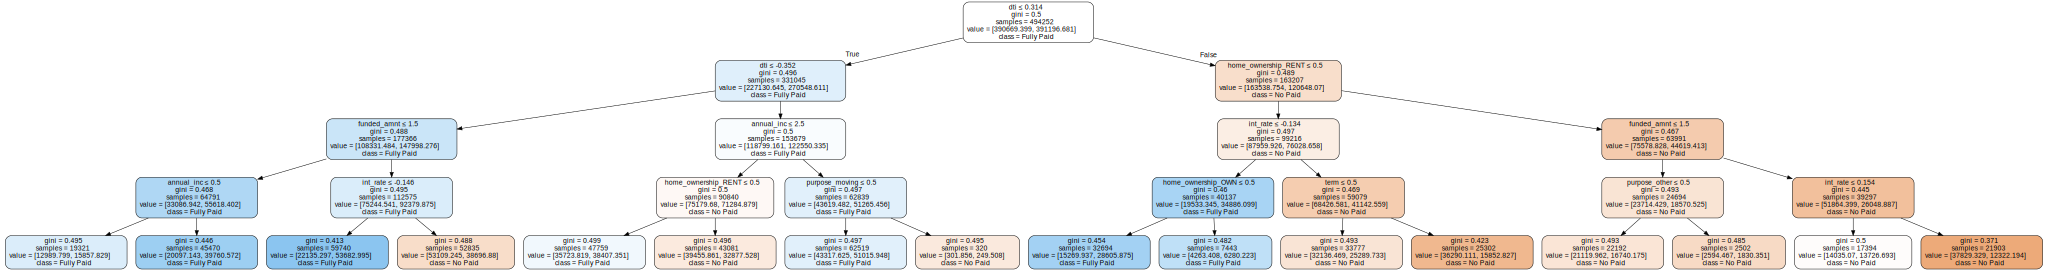

In [47]:
%%time
graph_tree(forest_model.estimators_[0], col_names=label_binarizer_mapper.transformed_names_)

array([4.92161272e-02, 2.25715202e-01, 5.56002260e-01, 1.35549383e-02,
       1.14776794e-06, 3.77066256e-02, 1.01044935e-03, 2.22645763e-02,
       1.72910133e-02, 1.32848237e-04, 1.00564814e-02, 6.75932506e-04,
       0.00000000e+00, 4.14778758e-04, 6.18745036e-06, 2.85535859e-06,
       4.46506240e-05, 3.74944193e-04, 3.33830014e-04, 1.23735427e-05,
       1.75732140e-03, 5.84563868e-07, 6.06071579e-05, 7.22163939e-05,
       8.42901075e-05, 6.32077583e-02])

CPU times: user 154 ms, sys: 23.7 ms, total: 178 ms
Wall time: 185 ms


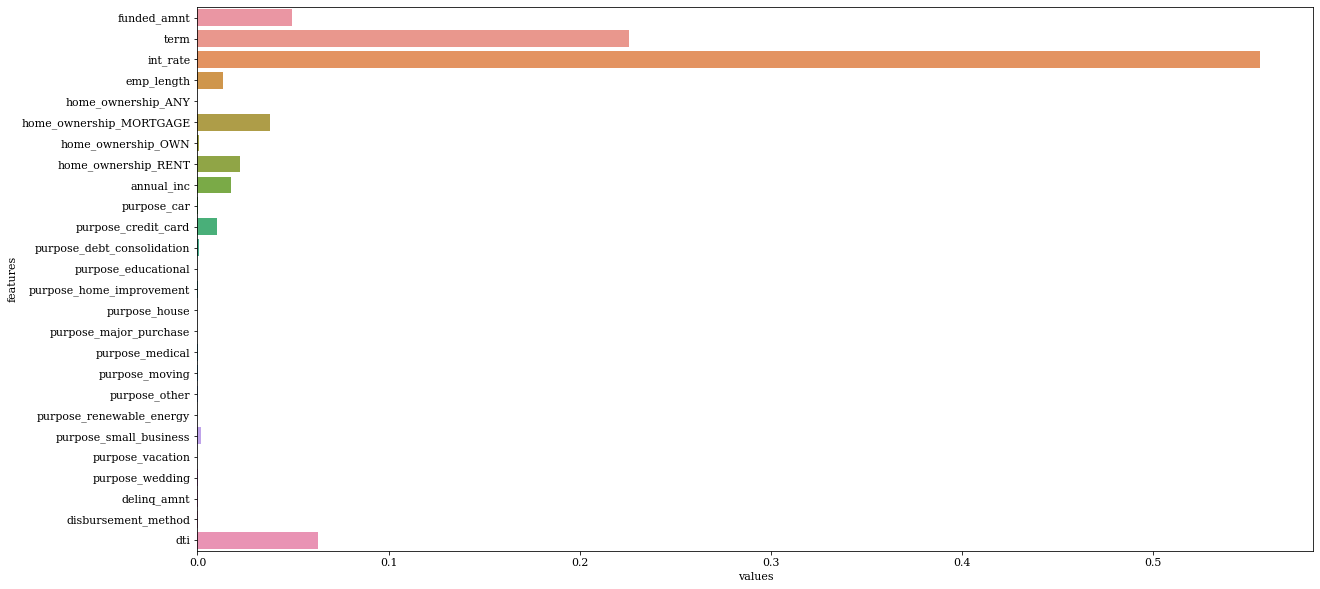

In [48]:
%%time
evaluate_feature(rf_model)

### Conclusión:

Con este modelo el valor de la métrica elegida es de: 0.882946 sobre el conjunto de datos de train. Lo que significa que la probabilidad de que el modelo acierte sobre los prestamos que se van a pagar es de aproximadamente 88%.

Para este modelo, tambien se tuvo que especificar algunos hiperparametros para evitar el sobreentrenamiento.

## Modelo 4: Gradient boosted trees

In [49]:
from sklearn.ensemble import GradientBoostingClassifier

In [50]:
%%time

boost_model = GradientBoostingClassifier(max_depth=3, n_estimators=100)

boo_model = Pipeline([
    ('mapper', label_binarizer_mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', boost_model),
])

boo_model.fit(train, train.loan_status)

CPU times: user 10min 50s, sys: 1min 27s, total: 12min 17s
Wall time: 5min 27s


Pipeline(steps=[('mapper',
                 DataFrameMapper(features=[(['funded_amnt'],
                                            [StandardScaler(),
                                             KBinsDiscretizer(encode='ordinal')]),
                                           (['term'], [LabelBinarizer()]),
                                           (['int_rate'], [StandardScaler()]),
                                           (['emp_length'], [StandardScaler()]),
                                           (['home_ownership'],
                                            [LabelBinarizer()]),
                                           (['annual_inc'],
                                            [StandardScaler(),
                                             KBinsDiscretizer(encode='ordinal')]),
                                           (['purpose'], [LabelBinarizer()]),
                                           (['delinq_amnt'],
                                            [StandardScal

'Gradient Boosting'

Accuracy  Precision    Recall
train  0.802060   0.807065  0.988830
test   0.800988   0.806269  0.988536

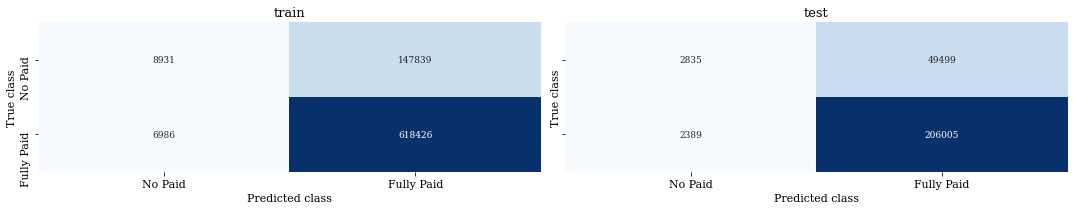

CPU times: user 13.9 s, sys: 456 ms, total: 14.4 s
Wall time: 14 s


In [51]:
%%time
evaluate_model(boo_model, title='Gradient Boosting')

CPU times: user 4.78 ms, sys: 118 µs, total: 4.89 ms
Wall time: 4.36 ms


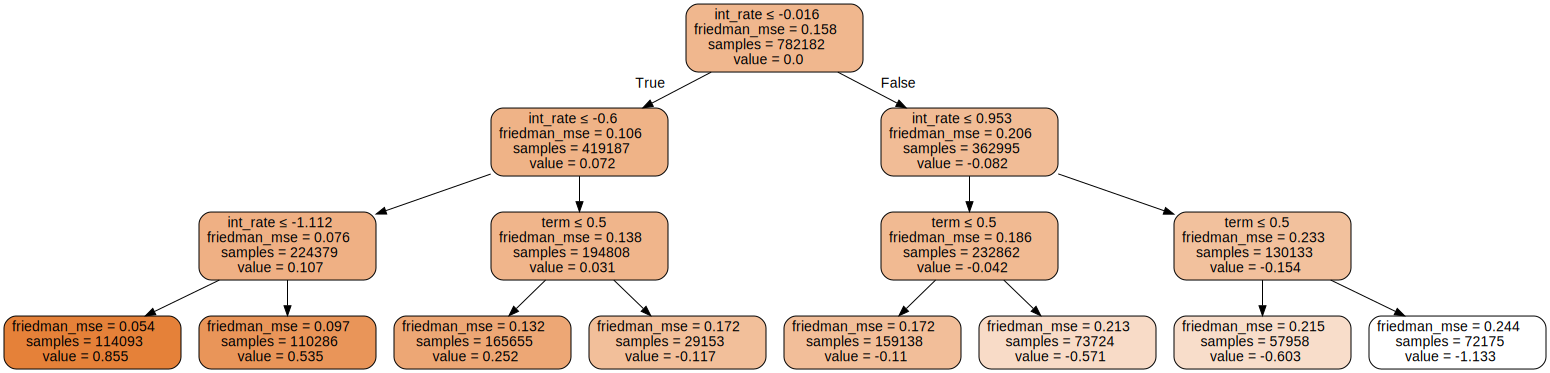

In [52]:
%%time
graph_tree(boost_model.estimators_[1][0], col_names=label_binarizer_mapper.transformed_names_)

array([1.87540307e-02, 9.50536177e-02, 7.20751329e-01, 2.44409087e-02,
       0.00000000e+00, 2.90966871e-02, 0.00000000e+00, 2.99967563e-02,
       1.90123019e-02, 8.84263509e-05, 2.99594604e-04, 4.04866385e-04,
       0.00000000e+00, 1.79939050e-04, 6.80844097e-05, 6.71329743e-04,
       1.12154692e-04, 2.04920161e-04, 1.29118643e-04, 0.00000000e+00,
       3.73307373e-03, 3.16162037e-04, 4.44329203e-04, 2.25696119e-04,
       4.00571994e-05, 5.59766164e-02])

CPU times: user 155 ms, sys: 11.9 ms, total: 167 ms
Wall time: 167 ms


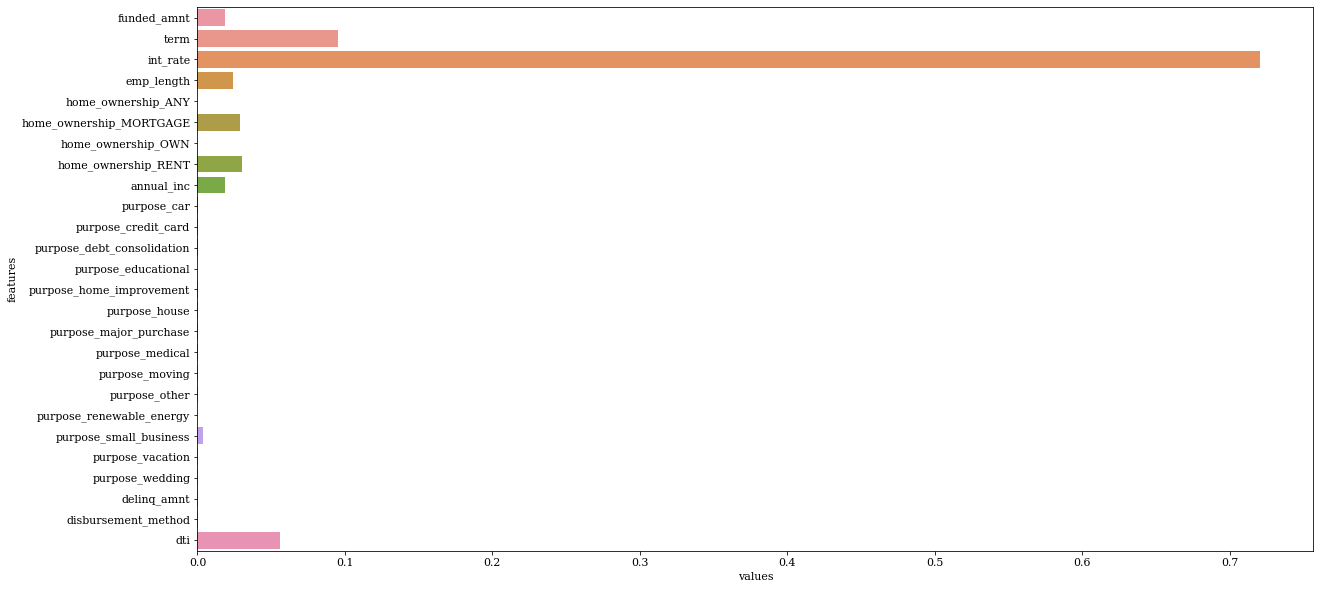

In [53]:
%%time
evaluate_feature(boo_model)

### Conclusión:

Con este modelo el valor de la métrica elegida es de: 0.806902 sobre el conjunto de datos de test, Lo cual significa que la certeza que se tiene de que un prestamo que se predice como "Fully Paid" lo sea es del 80%
Para este modelo, se tuvieron que especificar algunos hiperparametros para evitar el sobreentrenamiento, pero no se lograron buenos resultado, como se ve claramente en la matriz de confusión.

# EVALUACIÓN DE LOS MODELOS

In [54]:
%%time 
evaluate_model(lr_model, title='Regresion Logistica', set_names=('train', 'test', 'validation'), show_cm=False)
evaluate_model(dt_model, title='Decision Tree', set_names=('train', 'test', 'validation'), show_cm=False)
evaluate_model(rf_model, title='Random Forest', set_names=('train', 'test', 'validation'), show_cm=False)
evaluate_model(boo_model, title='Gradient Boosting', set_names=('train', 'test', 'validation'), show_cm=False)

'Regresion Logistica'

Accuracy  Precision    Recall
train       0.660259   0.874866  0.671084
test        0.660869   0.875171  0.671478
validation  0.660754   0.874850  0.671048

'Decision Tree'

Accuracy  Precision    Recall
train       0.628026   0.889972  0.610228
test        0.621813   0.884699  0.605790
validation  0.621755   0.882868  0.606694

'Random Forest'

Accuracy  Precision    Recall
train       0.619375   0.882429  0.604507
test        0.619891   0.882946  0.604586
validation  0.620647   0.882095  0.605786

'Gradient Boosting'

Accuracy  Precision    Recall
train       0.802060   0.807065  0.988830
test        0.800988   0.806269  0.988536
validation  0.800854   0.805776  0.988912

CPU times: user 51.5 s, sys: 1.78 s, total: 53.2 s
Wall time: 50 s


# Conclusión

Observamos que todos los modelos arrojan valores muy similares.

Entendemos que los primeros tres modelos no sobreentrenan, ya que los valores de train y test no presentan grandes variaciones, además, para corroborar utilizamos la matriz de confusión que nos permite comparar de forma grafica el desempeño del algoritmo. 
Cabe destacar que al usar precision en nuestro dataset, es esperado que el valor del la metrica sea elevado por la cantidad de casos positivos contenidos en el conjunto de datos. 

El modelo que elegimos es **Decision Tree** ya que el valor de la metrica obtenido en el conjunto de datos de test es el mas alto en comparación a los otros modelos entrenados y al ser un modelo de "caja blanca" nos permite entender cuales son las decisiones del mismo.


Al cliente, se le informaria que la certeza con la que el modelo predice correctamente es del 88% tomando como referencia los resultados obtenidos en el dataset de validation, es decir, cuando un prestamo se predice como Fully Paid hay un 88% de probabilidad de que esto sea verdad.

